# Spatial Analysis of Water Sendimentation

The data we are interested in is each water sedimentation study point with five miles buffer. For each remote sensing file, we make three ways to construct the classification methods, and select the most practical method to construct the land use classification. Because our study sample is very small in terms of most large deep learning model, so the best practible way is to first use unsupervised classificaiton method for each region and then 

The second method is to merge the study samples into a single unit and then classify them using unsupervised classification method. The last method is directly using ESRI pre-trained deep learning model.

In [5]:
# you need to download this package using kernel
# and you need to download and install other kernel packages in arcgis pro management environment
# pip install openeo

In [1]:
# this is the necessary packages for the code
import arcpy
from arcpy.sa import *
import os
import glob
import re
import openeo
import xarray
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely import Point, Polygon
import numpy as np
from datetime import datetime
import rasterio
from rasterio.transform import from_origin
from rasterio.transform import Affine
from rasterio.enums import Resampling
from osgeo import gdal

now change the working directory to the folder that you need to download the data into.

In [2]:
os.chdir(r'E:\umich\644 final project') # you need to change this to the directory that you are working on

## Downloading the Remote Sensing File

here we are reading a sediment examination point retrieved from the michigan river. For this project, we only consider six study points which are in Michigan during November, and for larger projects the code is still reusable and we can direclty run the codes to reimplement the result

In [12]:
data = pd.read_excel('sediment.xlsx')
data = data.dropna(how='all')
data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

breifly summarize the columns that we have

In [13]:
data.columns

Index(['ActivityStartDate', 'ActivityConductingOrganizationText',
       'MonitoringLocationIdentifier', 'latitude', 'longitude',
       'HydrologicEvent', 'CharacteristicName', 'ResultMeasureValue',
       'ResultMeasure/MeasureUnitCode', 'ResultStatusIdentifier', 'geometry'],
      dtype='object')

this function create a polygon around the point seriving as 5 miles buffer

In [14]:
def create_square_polygon(point, distance_miles):
    """_summary_
    Create a square polygon around the point with the specified distance in miles.
    
    Args:
        point: A Shapely Point object with longitude and latitude.
        distance_miles: Distance from the point to the edges of the square in miles.
    
    Returns a tuple with (min_lon, max_lon, min_lat, max_lat) representing the square.
    
    """
    miles_per_degree_lat = 69.0
    distance_degrees_lat = distance_miles / miles_per_degree_lat
    
    avg_lat = point.y
    miles_per_degree_lon = 69.172 * np.cos(np.radians(avg_lat))
    distance_degrees_lon = distance_miles / miles_per_degree_lon
    
    # Calculate square boundaries
    min_lon = point.x - distance_degrees_lon
    max_lon = point.x + distance_degrees_lon
    min_lat = point.y - distance_degrees_lat
    max_lat = point.y + distance_degrees_lat
    
    # Return the square as a tuple of its boundary coordinates
    return (min_lon, max_lon, min_lat, max_lat)


squares = data['geometry'].apply(lambda x: create_square_polygon(x, 5))
data['square_boundaries'] = squares

summarize the sample boundary

In [15]:
data['square_boundaries'][0]

(-84.5876081607477, -84.39395543925228, 41.63703103188406, 41.78195856811595)

now we need to convert the time to make it be appropriate to export to the extracted name. Note that the saved file is like "starting date" + "monitoring point"

In [16]:
data['ActivityStartDate'] = pd.to_datetime(data['ActivityStartDate'])

# Now convert to 'YYYY-MM-DD' format
data['ActivityStartDate'] = data['ActivityStartDate'].dt.strftime('%Y-%m-%d')

In [17]:
data['name'] = data['ActivityStartDate'] + '_' + data['MonitoringLocationIdentifier']
data['name'] = data['name'].str.replace('-', '_', regex=False)

now we connect to the open website to get the data downloaded. The data we are interesting is the sentinel-2 data L2A data. It consists of 12 bands and more other supportive bands. So we can directly download them

In [18]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with NullAuth>

Note the NullAuth in the representation of the connection, which indicates that we are not logged in yet.

The canonical way to log in is using the authenticate_oidc() method. This might, depending on your situation, trigger an authentication procedure. Follow the instructions, if any.

In [19]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

Note that the connection is now authenticated now through OidcBearerAuth.

With our authenticated connection, we can now start loading a data collection data to build a DataCube, filtered according to specific spatio-temporal constraints:

now give a test for the first object

In [20]:
data['ActivityStartDate'] = pd.to_datetime(data['ActivityStartDate'])
data['StartOfMonth'] = data['ActivityStartDate'].dt.to_period('M').dt.start_time
data['EndOfMonth'] = data['ActivityStartDate'].dt.to_period('M').dt.end_time
data['EndOfMonth'] = data['EndOfMonth'].dt.date

take a look at the first sample

In [21]:
i = 0
data['StartOfMonth'][i].strftime('%Y-%m-%d')

'2020-11-01'

the bright clouds ruin the composite image.

## Cloud masking

First we build a binary cloud mask from the SCL values 3 (cloud shadows), 8 (cloud medium probability) and 9 (cloud high probability):

specify the bands that we are going to download

In [22]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

this is the downloading function and

In [16]:

for i in range(len(data)):
    start_date_iso = data['StartOfMonth'][i].strftime('%Y-%m-%d')
    end_date_iso = data['EndOfMonth'][i].strftime('%Y-%m-%d')

    # First, download the SCL band separately
    s2_cube_scl = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=(start_date_iso, end_date_iso),
        spatial_extent={
            "west": data['square_boundaries'][i][0],
            "south": data['square_boundaries'][i][2],
            "east": data['square_boundaries'][i][1],
            "north": data['square_boundaries'][i][3],
            "crs": "EPSG:4326",
        },
        bands=['SCL'],
        max_cloud_cover=50,
    )
    scl_band = s2_cube_scl.band("SCL")
    cloud_mask = (scl_band == 3) | (scl_band == 8) | (scl_band == 9)
    cloud_mask = cloud_mask.resample_cube_spatial(s2_cube_scl)
    
    for j in bands:
        # Now load each spectral band and apply the SCL mask
        s2_cube = connection.load_collection(
            "SENTINEL2_L2A",
            temporal_extent=(start_date_iso, end_date_iso),
            spatial_extent={
                "west": data['square_boundaries'][i][0],
                "south": data['square_boundaries'][i][2],
                "east": data['square_boundaries'][i][1],
                "north": data['square_boundaries'][i][3],
                "crs": "EPSG:4326",
            },
            bands=[j],
            max_cloud_cover=50,
        )
        # Apply the previously downloaded cloud mask
        cube_masked = s2_cube.mask(cloud_mask)
        
        day_of_month = data['ActivityStartDate'][i].day
        if day_of_month > 20:
            result_cube = cube_masked.max_time()
        elif day_of_month > 10:
            result_cube = cube_masked.median_time()
        else:
            result_cube = cube_masked.min_time()
        
        result_cube.download("{}_{}.nc".format(data['name'][i], j))

print("Downloads complete.")


Downloads complete.


We can check it out for the first data and try to plot it

In [23]:
ds = xarray.load_dataset("{}_{}.nc".format(data['name'][0], bands[0])) 
# Convert xarray DataSet to a (bands, t, x, y) DataArray
# des = ds[bands[0]].to_array(dim="bands")

In [24]:
ds[bands[0]].plot.imshow(vmin=0, vmax=2000) # plotting the result

now we make another directory named "outputs" and we now convert the .nc file format to .tif for further analysis

In [28]:
if os.path.exists("../outputs"):
    pass
else:
    os.makedirs("../outputs")

In [3]:
name_list = []
entries = os.listdir()
for file in entries:
    if file.endswith(".nc"):
        name_list.append(file)

output_list = [file.replace('.nc', '.tif') for file in name_list]
for i in range(0, len(output_list)):
    output_list[i] = "../outputs/" + output_list[i]
    # os.path.join("../outputs", output_list[i])

now we convert the files to tiff format so that we can use it in our further analysis. The output format is float32

In [12]:
# Assuming name_list and output_list are defined somewhere above
from rasterio.crs import CRS
crs = CRS.from_proj4("+proj=longlat +datum=WGS84 +no_defs")
for i in range(len(name_list)):
    # Load the dataset
    data = xarray.load_dataset(name_list[i])
    pattern = re.compile(r"_(B\d+[A-Z]?)")
    band = pattern.search(name_list[i]).group(1)
    # Print available data variables
    # print(f"Available variables in dataset {i}: {list(data.data_vars)}")
    band_name = band  # Assuming 'bands' has the intended band names
    if band_name not in data.data_vars:
        print(f"Band '{band_name}' not found in dataset {i}.")
        continue  # Skip this iteration if the band is not found

    # Accessing the single band data
    des = data[band_name].values

    # Accessing the coordinates
    x = data.x.values
    y = data.y.values

    # Calculate pixel sizes
    pixel_size_x = x[1] - x[0]
    pixel_size_y = y[0] - y[1]

    # Define the transform
    transform = Affine(pixel_size_x, 0, x[0],
                       0, -pixel_size_y, y[0])
    
    # Open the output raster file for writing
    with rasterio.open(
        output_list[i], 
        'w',
        driver='GTiff',
        height=des.shape[0],  # Height from the shape of the 2D array
        width=des.shape[1],   # Width from the shape of the 2D array
        count=1,  # Only one band
        dtype=des.dtype,
        crs=crs,
        transform=transform
    ) as dst:
        # Write the single band to the files
        dst.write(des, 1)


we can also build Pyramids information on these tiff files. We can list all the files in the output directory

In [13]:
name_list = []
for file in os.listdir("../outputs"):
    if file.endswith(".tif"):
        name_list.append(file)

now change to the directory that have the .tif files and then we construct our analysis samples

In [14]:
os.chdir('../outputs')

In [15]:
for i in range(0, len(name_list)):
    raster_path = name_list[i]
    # Optional parameters for building pyramids
    pyramid_levels = ""  # Specify the number of levels or leave as an empty string
    resampling_technique = "NEAREST"  # Options: NEAREST, BILINEAR, CUBIC, MAJORITY
    compression_type = "DEFAULT"  # Compression type
    compression_quality = "75"  # Compression quality (for applicable formats)
    skip_existing = "SKIP_EXISTING"  # Whether to skip building pyramids for rasters that already have them

    # Build or rebuild pyramids
    arcpy.BuildPyramids_management(raster_path, \
                               pyramid_levels, \
                               "NONE",  # SKIP_FIRST is not applicable here; use "NONE" for no skipping
                               resampling_technique, 
                               compression_type, 
                               compression_quality, 
                               skip_existing)

print("Pyramids built successfully.")

Pyramids built successfully.


list all the sample data that we have been downloaded from the openeo website and we now need to combine selected bandswidth to use in the future work

In [16]:
def extract_matched_parts(filenames, pattern):
    extracted_parts = []
    for name in filenames:
        match = re.match(pattern, name)
        if match:
            # Append the captured part of the filename (everything before _Bxx.tif)
            extracted_parts.append(match.group(1))
    return extracted_parts


pattern = r'(.+)_B.*\.tif$'
matched_filenames = extract_matched_parts(name_list, pattern)
result = set(matched_filenames)
result = list(result)
# result = [x + ".tif" for x in result]

select the bands that we are interested in

In [17]:
bands = ['B02', 'B03', 'B04', 'B08']
nc_files = []
for i in range(0, len(result)):
    nc_files.append([f"{result[i]}_{band}.tif" for band in bands])

now we merge the bands that we are interested in and then we need to composite them to a single file for each research area

In [18]:
# Loop through each set of bands
for file_group in nc_files:
    # Extract the base name without the band part for use as the output filename
    base_name = file_group[0].split("_B")[0]
    output_path = f"../644 final project/{base_name}_composite.tif"
    
    # Combine the bands into a single raster
    arcpy.CompositeBands_management(file_group, output_path)
    print(f"Composite image created: {output_path}")

Composite image created: ../644 final project/2020_11_12_USGS_04177080_composite.tif
Composite image created: ../644 final project/2020_11_09_USGS_04157005_composite.tif
Composite image created: ../644 final project/2020_11_10_USGS_04142000_composite.tif
Composite image created: ../644 final project/2020_11_17_USGS_04040000_composite.tif
Composite image created: ../644 final project/2020_11_23_USGS_04119400_composite.tif
Composite image created: ../644 final project/2020_11_19_USGS_04059500_composite.tif


change back to our directory and then export the .tif files to that given directory

In [19]:
os.chdir('../644 final project')

In [20]:
name_list = []
for file in os.listdir():
    if file.endswith(".tif"):
        name_list.append(file)

check out the data and then we need to consider whether they are good

In [21]:
with rasterio.open(name_list[0]) as src:
    print(f"Number of bands: {src.count}")
    # Optionally, print each band's data type
    for i in range(src.count):
        print(f"Band {i+1} data type: {src.dtypes[i]}")

Number of bands: 4
Band 1 data type: float32
Band 2 data type: float32
Band 3 data type: float32
Band 4 data type: float32


now we list all the files and check the maximum and minimum value of each result

In [22]:
raster = arcpy.Raster(name_list[0])

# Get the count of bands in the raster
band_count = raster.bandCount

arcpy.management.CalculateStatistics(name_list[0])

# Create a Raster object
raster = arcpy.Raster(name_list[0])

# Print the number of bands
print(f"Total bands: {raster.bandCount}")

# Loop through each band to get min and max values
for i in range(1, raster.bandCount + 1):
    # For each band, get the minimum value
    min_val = arcpy.GetRasterProperties_management(name_list[0], "MINIMUM", f"Band_{i}")
    # For each band, get the maximum value
    max_val = arcpy.GetRasterProperties_management(name_list[0], "MAXIMUM", f"Band_{i}")
    
    # Print the min and max values for each band
    print(f"Band {i}:")
    print(f" Minimum value: {min_val.getOutput(0)}")
    print(f" Maximum value: {max_val.getOutput(0)}")

Total bands: 4
Band 1:
 Minimum value: -596
 Maximum value: 6640
Band 2:
 Minimum value: -596
 Maximum value: 6640
Band 3:
 Minimum value: -596
 Maximum value: 6640
Band 4:
 Minimum value: -596
 Maximum value: 6640


now we check the spatial reference and check out the pixel type for each file

In [23]:
# we first need some verification

for raster in name_list:
    if arcpy.Exists(raster):
        # Get raster description
        desc = arcpy.Describe(raster)
        # Spatial reference
        spatial_ref = desc.spatialReference.name if desc.spatialReference else "None"
        print(f"Spatial Reference for {raster}: {spatial_ref}")
        
        # Pixel type
        pixel_type = arcpy.GetRasterProperties_management(raster, "VALUETYPE").getOutput(0)
        print(f"Pixel Type for {raster}: {pixel_type}")
        
        # Number of bands
        band_count = desc.bandCount
        print(f"Number of Bands in {raster}: {band_count}")


Spatial Reference for 2020_11_09_USGS_04157005_composite.tif: GCS_unknown
Pixel Type for 2020_11_09_USGS_04157005_composite.tif: 9
Number of Bands in 2020_11_09_USGS_04157005_composite.tif: 4
Spatial Reference for 2020_11_10_USGS_04142000_composite.tif: GCS_unknown
Pixel Type for 2020_11_10_USGS_04142000_composite.tif: 9
Number of Bands in 2020_11_10_USGS_04142000_composite.tif: 4
Spatial Reference for 2020_11_12_USGS_04177080_composite.tif: GCS_unknown
Pixel Type for 2020_11_12_USGS_04177080_composite.tif: 9
Number of Bands in 2020_11_12_USGS_04177080_composite.tif: 4
Spatial Reference for 2020_11_17_USGS_04040000_composite.tif: GCS_unknown
Pixel Type for 2020_11_17_USGS_04040000_composite.tif: 9
Number of Bands in 2020_11_17_USGS_04040000_composite.tif: 4
Spatial Reference for 2020_11_19_USGS_04059500_composite.tif: GCS_unknown
Pixel Type for 2020_11_19_USGS_04059500_composite.tif: 9
Number of Bands in 2020_11_19_USGS_04059500_composite.tif: 4
Spatial Reference for 2020_11_23_USGS_04

after we have classified the data and because our different types of results have different range so we need to use map algebra to transform the classification results to a single comparable level

here we consider the minimal cell size of each file

In [24]:
# Initialize a list to store cell sizes
cell_sizes = []

# Loop through each raster to get its cell size
for raster_path in name_list:
    raster = arcpy.Raster(raster_path)
    # Get the cell size properties
    cell_size_x = raster.meanCellWidth
    cell_size_y = raster.meanCellHeight
    
    # Optionally, average the cell size if it's not square, but usually, they should be the same
    mean_cell_size = (cell_size_x + cell_size_y) / 2
    cell_sizes.append(mean_cell_size)

# Use the smallest cell size for the mosaic
min_cell_size = min(cell_sizes)
print(f"Minimum cell size to use: {min_cell_size}")

Minimum cell size to use: 10.0


this is the code for merging the multiple small area study sample to get a whole picture of the whole area. This method should be taken out of control if the study area is from one area to another area that is far away.

**You should be careful in executing this code because the running time is pretty long**

In [ ]:
output_tiff = f"merged2.tif"
    
output_pixel_type = "32_BIT_FLOAT"  # Choose based on your data, e.g., 16_BIT_UNSIGNED, 32_BIT_FLOAT
number_of_bands = 4
cell_size = 10  # Specify or leave as an empty string to use the source
mosaic_method = "LAST"  # LAST, FIRST, BLEND, MEAN, MINIMUM, MAXIMUM
spatial_ref = arcpy.SpatialReference(4326)
# Execute MosaicToNewRaster
arcpy.management.MosaicToNewRaster(name_list, arcpy.env.workspace, output_tiff, spatial_ref, output_pixel_type, cell_size, number_of_bands,\
                                           "LAST","Reject")
print(f"The {number_of_bands} files have been combined into a multi-band TIFF file.")

plot the area

In [ ]:
original_graph = output_tiff
data = Raster(output_tiff)
data

## Method 1

Classification using unsupervised classification method and then automatically generate labels

In [25]:
input_raster_problem = arcpy.Raster(name_list[5])

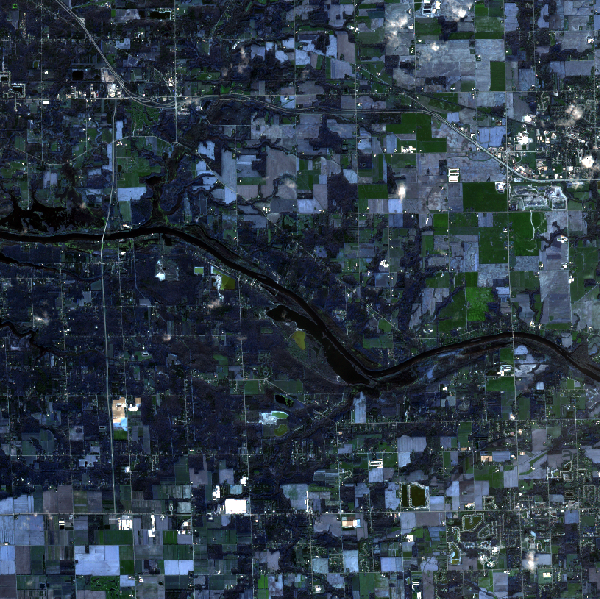

In [26]:
input_raster_problem

In [27]:
input_raster = arcpy.Raster(name_list[4])

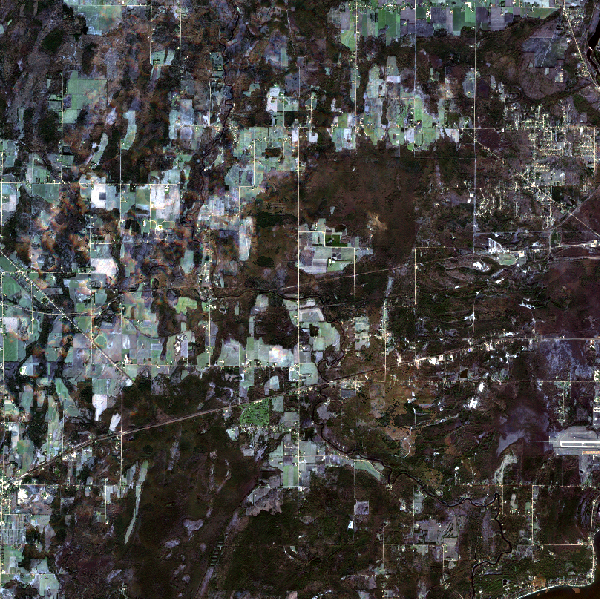

In [28]:
input_raster

now we consider multiple areas and in each area we classify the tiff result to multiple classes and then consider for each area the result.

In [29]:
name_list[0]

'2020_11_09_USGS_04157005_composite.tif'

we need to normalize the band information before we use unsupervised classification method in this setting

In [30]:
arcpy.env.workspace = os.path.abspath("../644 final project")
if not os.path.exists("../result"):
    os.makedirs("../result")
arcpy.env.overwriteOutput = True
for i in range(0, len(name_list)):
    
    input_raster_file = os.path.abspath(os.path.join(arcpy.env.workspace, name_list[i]))
  # Your 4-band input TIFF file
    # Set the number of classes for the classification
    num_classes = 8

    # Set the minimum number of cells in each class (optional)
    minimum_class_size = 2

    # Set the sampling interval (optional)
    sample_interval = 10

    # Define the output signature file path (optional)
    output_signature_file = os.path.join('../result', "classification_signatures.gsg")
    
    # Perform the unsupervised classification
    out_unsupervised_classification = arcpy.sa.IsoClusterUnsupervisedClassification(input_raster_file, 
    num_classes, 
    minimum_class_size, 
    sample_interval)

    classified_raster = "../result/{}.tif".format(name_list[i].replace('.tif', '_classified'))
    out_unsupervised_classification.save(classified_raster)

now we output it to shapefile version. This will take some time and the exported result is a shapefile that we has number of classes distinct values

In [31]:
for i in range(0, len(name_list)):
    classified_raster = "../result/{}.tif".format(name_list[i].replace('.tif', '_classified'))
    output_shapefile = "../result/{}.shp".format(name_list[i].replace('.tif', '_classified'))
    arcpy.RasterToPolygon_conversion(classified_raster, output_shapefile, "NO_SIMPLIFY", "VALUE")

Now, the idea is that we first extract the attributes of different types of regions using different methods, and then we choose the ones that are most likely to label our unsupervised learning results

In [32]:
# we first create a direcotry to store the result
if not os.path.exists("../index_result"):
    os.makedirs("../index_result")

### Detecting Water

NDWI utilizes the green and NIR bands to enhance presence of water bodies while supressing other features

$$
NDWI = \frac{(Green - NIR)}{(Green + NIR)}
$$

For Sentinel-2, you can use Band 3 (Green, 560 nm) and Band 8 (NIR, 842 nm).

We can also use the modified nomalized difference water index (MNDWI)

The Modified NDWI (MNDWI) uses Green and SWIR bands to further suppress built-up land features and vegetation, improving water extraction accuracy.

$$
MNDWI = \frac{(Green - SWIR)}{(Green + SWIR)}
$$

We now work on the NDWI using python

In [33]:
def calculate_mndwi(green_path, swir_path):
    with rasterio.open(green_path) as green_src, rasterio.open(swir_path) as swir_src:
        green = green_src.read(1, out_shape=(green_src.height, green_src.width), resampling=Resampling.bilinear)
        swir = swir_src.read(1, out_shape=(swir_src.height, swir_src.width), resampling=Resampling.bilinear)

        mndwi = (green.astype(float) - swir.astype(float)) / (green + swir + 1e-10)  # Avoid division by zero
        water_mask = mndwi > 0.0  # Threshold can be adjusted based on the scene and requirements

        return water_mask

for i in range(0, len(name_list)):
    green_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B03'))
    nir_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B08'))
    # now calculate the mndwi index and export it to .tif
    water_mask = calculate_mndwi(green_band_path, nir_band_path)

    with rasterio.open(green_band_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=1)
        with rasterio.open(os.path.join("../index_result", 'water_mask_{}.tif'.format(name_list[i].replace('_composite', '_water'))), 'w', **profile) as dst:
            dst.write((water_mask * 255).astype(rasterio.uint8), 1)  # Convert boolean mask to uint8


# Here, you could save `water_mask` as a new raster or visualize it using matplotlib
plt.imshow(water_mask, cmap='Blues')
plt.colorbar(label='NDWI Value')
plt.title('Water Mask')
plt.xlabel('Pixel')
plt.ylabel('Line')
plt.show()

In [34]:
os.chdir('../644 final project')
name_list = []
for file in os.listdir():
    if file.endswith(".tif"):
        name_list.append(file)

In [35]:
name_list[0]

'2020_11_09_USGS_04157005_composite.tif'

In [36]:
from arcpy.sa import ZonalStatisticsAsTable
# Setup arcpy environment settings
arcpy.env.workspace = "../result"  # Adjust this to your workspace
arcpy.env.overwriteOutput = True

for i in range(0, len(name_list)):
    shapefile_path = "../result/{}.shp".format(name_list[i].replace('.tif', '_classified'))
    # shapes = gpd.read_file(shapefile_path)
    
    water_tiff_path = os.path.join('../index_result', 'water_mask_{}.tif'.format(name_list[i].replace('_composite', '_water')))
    # centroids = shapes.geometry.centroid
    output_table = "../Urban-Effect-Of-Water-Sediment/{}.dbf".format(name_list[i].replace("_composite.tif", "_water"))

    ZonalStatisticsAsTable(shapefile_path, "Id", water_tiff_path, output_table, "DATA", "SUM")
    print("Having Extracted the Number of Water Pixels for {}".format(name_list[i]))

Having Extracted the Number of Water Pixels for 2020_11_09_USGS_04157005_composite.tif
Having Extracted the Number of Water Pixels for 2020_11_10_USGS_04142000_composite.tif
Having Extracted the Number of Water Pixels for 2020_11_12_USGS_04177080_composite.tif
Having Extracted the Number of Water Pixels for 2020_11_17_USGS_04040000_composite.tif
Having Extracted the Number of Water Pixels for 2020_11_19_USGS_04059500_composite.tif
Having Extracted the Number of Water Pixels for 2020_11_23_USGS_04119400_composite.tif


In [37]:
def construct_by_sum(data_column, file_path_last_symbols):
    # the symbol is the last item that should be replacing the _composite in the name_list
    # the gride name is the one that is placing in the dataframe
    all_results = pd.DataFrame()

    for i in range(0, len(name_list)):
        shapefile_path = "../result/{}.shp".format(name_list[i].replace('.tif', '_classified'))
        shapes = gpd.read_file(shapefile_path)
        dbf_file_path = "../Urban-Effect-Of-Water-Sediment/{}.dbf".format(name_list[i].replace("_composite.tif", file_path_last_symbols))
        gdf = gpd.read_file(dbf_file_path)
        # print(gdf.head())

        shapes['Id'] = shapes['Id'].astype(str)
        gdf['Id'] = gdf['Id'].astype(str)

        merged_df = pd.merge(gdf, shapes[['Id', 'gridcode']], on='Id', how='left')

        grouped_means = pd.DataFrame(merged_df.groupby('gridcode')['SUM'].sum())
        grouped_means.reset_index(drop = False, inplace = True)
        grouped_means.columns = ['gridcode', data_column]
        grouped_means['source'] = name_list[i].replace("_composite.tif", file_path_last_symbols)
        if i == 0:
            all_results = grouped_means
        else:
            all_results = pd.concat([all_results, grouped_means], ignore_index=True)
    
    return all_results

In [38]:
water_result = construct_by_sum("water_pixels", "_water")

Therefore, we can see from the result that the first label is the **water**

In [39]:
water_result

,gridcode,water_pixels,source
0,1,5304255.0,2020_11_09_USGS_04157005_water
1,2,4080.0,2020_11_09_USGS_04157005_water
2,3,0.0,2020_11_09_USGS_04157005_water
3,4,1154895.0,2020_11_09_USGS_04157005_water
4,5,7905.0,2020_11_09_USGS_04157005_water
5,6,255.0,2020_11_09_USGS_04157005_water
6,7,378930.0,2020_11_09_USGS_04157005_water
7,8,3315.0,2020_11_09_USGS_04157005_water
8,1,2790975.0,2020_11_10_USGS_04142000_water
9,2,0.0,2020_11_10_USGS_04142000_water


```
import rasterstats
from osgeo import gdal
zonal_stats_result = rasterstats.zonal_stats(shapes, water_tiff_path, stats="mean", geojson_out=True, nodata=-9999)
```

this is too slow in executing

### Now we work on the bareland  detection

The Bare Soil Index (BSI) is particularly useful for emphasizing areas with bare soil. It exploits the fact that bare soil has a higher reflectance in the red and SWIR bands compared to vegetation.

Formula is 

$$
BSI = \frac{(SWIR + RED) - (NIR + BLUE)}{(SWIR + RED) + (NIR + BLUE)}
$$

Sentinel-2 Bands: SWIR (Band 11, 1610 nm or Band 12, 2190 nm), Red (Band 4, 665 nm), NIR (Band 8, 842 nm), and Blue (Band 2, 490 nm).

In [40]:
def calculate_bsi(red_path, nir_path, swir_path, blue_path):
    with rasterio.open(red_path) as red_src, rasterio.open(nir_path) as nir_src, \
         rasterio.open(swir_path) as swir_src, rasterio.open(blue_path) as blue_src:
         
        red = red_src.read(1).astype(float)
        nir = nir_src.read(1).astype(float)
        swir = swir_src.read(1).astype(float)
        blue = blue_src.read(1).astype(float)

        # Calculate BSI
        bsi = ((swir + red) - (nir + blue)) / ((swir + red) + (nir + blue) + 1e-10)  # Avoid division by zero

        return bsi


for i in range(0, len(name_list)):
    red_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B04'))
    swir_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B11'))
    nir_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B08'))
    blue_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B02'))
    # now calculate the mndwi index and export it to .tif
    bsi_index = calculate_bsi(red_band_path, nir_band_path, swir_band_path, blue_band_path)
    
    bsi_index = bsi_index > 0.2
    with rasterio.open(red_band_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=1)
        with rasterio.open(os.path.join("../index_result", 'soil_mask_{}.tif'.format(name_list[i].replace('_composite', '_soil'))), 'w', **profile) as dst:
            dst.write((bsi_index * 255).astype(rasterio.uint8), 1)  # Convert boolean mask to uint8


# Visualize the refined urban areas mask
plt.figure(figsize=(10, 5))
plt.imshow(bsi_index, cmap='gray')
plt.colorbar(label='Soil Area Mask')
plt.title('Refined Soil Areas Detection')
plt.xlabel('Pixel')
plt.ylabel('Line')
plt.show()

In [41]:
from arcpy.sa import ZonalStatisticsAsTable
# Setup arcpy environment settings
arcpy.env.workspace = "../result"  # Adjust this to your workspace
arcpy.env.overwriteOutput = True

for i in range(0, len(name_list)):
    shapefile_path = "../result/{}.shp".format(name_list[i].replace('.tif', '_classified'))
    # shapes = gpd.read_file(shapefile_path)
    
    soil_tiff_path = os.path.join('../index_result', 'soil_mask_{}.tif'.format(name_list[i].replace('_composite', '_soil')))
    # centroids = shapes.geometry.centroid
    output_table = "../Urban-Effect-Of-Water-Sediment/{}.dbf".format(name_list[i].replace("_composite.tif", "_soil"))

    ZonalStatisticsAsTable(shapefile_path, "Id", soil_tiff_path, output_table, "DATA", "SUM")
    print("Having Extracted the Number of Soil Pixels for {}".format(name_list[i]))

Having Extracted the Number of Soil Pixels for 2020_11_09_USGS_04157005_composite.tif
Having Extracted the Number of Soil Pixels for 2020_11_10_USGS_04142000_composite.tif
Having Extracted the Number of Soil Pixels for 2020_11_12_USGS_04177080_composite.tif
Having Extracted the Number of Soil Pixels for 2020_11_17_USGS_04040000_composite.tif
Having Extracted the Number of Soil Pixels for 2020_11_19_USGS_04059500_composite.tif
Having Extracted the Number of Soil Pixels for 2020_11_23_USGS_04119400_composite.tif


In [42]:
soil_result = construct_by_sum("soil_pixels", "_soil")

In [43]:
soil_result

,gridcode,soil_pixels,source
0,1,31261470.0,2020_11_09_USGS_04157005_soil
1,2,82867095.0,2020_11_09_USGS_04157005_soil
2,3,11778705.0,2020_11_09_USGS_04157005_soil
3,4,60469425.0,2020_11_09_USGS_04157005_soil
4,5,22189845.0,2020_11_09_USGS_04157005_soil
5,6,59160.0,2020_11_09_USGS_04157005_soil
6,7,7286625.0,2020_11_09_USGS_04157005_soil
7,8,14535.0,2020_11_09_USGS_04157005_soil
8,1,29285220.0,2020_11_10_USGS_04142000_soil
9,2,36241110.0,2020_11_10_USGS_04142000_soil


In [44]:
# Define the index list for the rows you want to reserve
index_list = list(range(8))  # This will create a list [0, 1, 2, ..., 7]

# Initialize the DataFrame with NaNs (or any other placeholder)
filtration_result = pd.DataFrame(index=index_list, columns=name_list).fillna(np.nan)

### now we work on urban area

In [45]:
os.chdir('../644 final project')
name_list = []
for file in os.listdir():
    if file.endswith(".tif"):
        name_list.append(file)

We can use NDBI to classify the result. 

The NDBI is widely used for identifying built-up areas. It leverages the fact that urban areas tend to have higher reflectance in the short-wave infrared (SWIR) range compared to the NIR range.

$$
NDBI = \frac{SWIR - NIR}{NIR + SWIR}
$$

For Sentinel-2, Band 8 (NIR, 842 nm) and Band 11 (SWIR, 1610 nm) are typically used.

The Urban Index is another method to enhance urban areas by using the difference between NIR and SWIR bands. Formula is

$$
UI = \frac{NIR - SWIR}{NIR + SWIR}
$$

Sentinel-2 Bands: For Sentinel-2, Band 8 (NIR, 842 nm) and Band 11 (SWIR, 1610 nm) are typically used.



In [46]:
def calculate_ndvi(nir_path, red_path):
    with rasterio.open(nir_path) as nir_src, rasterio.open(red_path) as red_src:
        nir = nir_src.read(1).astype(float)
        red = red_src.read(1).astype(float)

        # Calculate NDVI
        ndvi = (nir - red) / (nir + red + 1e-10)  # Avoid division by zero
        return ndvi

def calculate_ndbi(nir_path, swir_path):
    with rasterio.open(nir_path) as nir_src, rasterio.open(swir_path) as swir_src:
        nir = nir_src.read(1).astype(float)
        swir = swir_src.read(1).astype(float)

        # Calculate NDBI
        ndbi = (swir - nir) / (swir + nir + 1e-10)  # Avoid division by zero
        return ndbi

for i in range(0, len(name_list)):
    red_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B04'))
    swir_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B11'))
    nir_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B08'))
    # now calculate the mndwi index and export it to .tif
    ndvi = calculate_ndvi(nir_band_path, red_band_path)
    ndbi = calculate_ndbi(nir_band_path, swir_band_path)

    # Assuming urban areas have low NDVI and high NDBI
    # Apply a mask to reduce false positives in mountainous regions
    urban_mask = (ndbi > 0.1) & (ndvi < 0.2)  # Thresholds can be adjusted based on analysis needs

    with rasterio.open(red_band_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=1)
        with rasterio.open(os.path.join("../index_result", 'urban_mask_{}.tif'.format(name_list[i].replace('_composite', '_urban'))), 'w', **profile) as dst:
            dst.write((urban_mask * 255).astype(rasterio.uint8), 1)  # Convert boolean mask to uint8


# Visualize the refined urban areas mask
plt.figure(figsize=(10, 5))
plt.imshow(urban_mask, cmap='gray')
plt.colorbar(label='Urban Area Mask')
plt.title('Refined Urban Areas Detection')
plt.xlabel('Pixel')
plt.ylabel('Line')
plt.show()

In [47]:
from arcpy.sa import ZonalStatisticsAsTable
# Setup arcpy environment settings
arcpy.env.workspace = "../result"  # Adjust this to your workspace
arcpy.env.overwriteOutput = True

for i in range(0, len(name_list)):
    shapefile_path = "../result/{}.shp".format(name_list[i].replace('.tif', '_classified'))
    # shapes = gpd.read_file(shapefile_path)
    
    urban_tiff_path = os.path.join('../index_result', 'urban_mask_{}.tif'.format(name_list[i].replace('_composite', '_urban')))
    # centroids = shapes.geometry.centroid
    output_table = "../Urban-Effect-Of-Water-Sediment/{}.dbf".format(name_list[i].replace("_composite.tif", "_urban"))

    ZonalStatisticsAsTable(shapefile_path, "Id", urban_tiff_path, output_table, "DATA", "SUM")
    print("Having Extracted the Number of Urban Pixels for {}".format(name_list[i]))

Having Extracted the Number of Urban Pixels for 2020_11_09_USGS_04157005_composite.tif
Having Extracted the Number of Urban Pixels for 2020_11_10_USGS_04142000_composite.tif
Having Extracted the Number of Urban Pixels for 2020_11_12_USGS_04177080_composite.tif
Having Extracted the Number of Urban Pixels for 2020_11_17_USGS_04040000_composite.tif
Having Extracted the Number of Urban Pixels for 2020_11_19_USGS_04059500_composite.tif
Having Extracted the Number of Urban Pixels for 2020_11_23_USGS_04119400_composite.tif


In [48]:
urban_result = construct_by_sum("urban_pixels", "_urban")

Therefore, we can see from the result that the first label is the **urban area**

In [49]:
urban_result

,gridcode,urban_pixels,source
0,1,5803545.0,2020_11_09_USGS_04157005_urban
1,2,22144200.0,2020_11_09_USGS_04157005_urban
2,3,5865.0,2020_11_09_USGS_04157005_urban
3,4,35512830.0,2020_11_09_USGS_04157005_urban
4,5,14478645.0,2020_11_09_USGS_04157005_urban
5,6,255.0,2020_11_09_USGS_04157005_urban
6,7,14105580.0,2020_11_09_USGS_04157005_urban
7,8,5355.0,2020_11_09_USGS_04157005_urban
8,1,3594225.0,2020_11_10_USGS_04142000_urban
9,2,768060.0,2020_11_10_USGS_04142000_urban


### Now we work on the vegetation index

Normalized Difference Vegetation Index (NDVI)

$$
NDVI = \frac{(NIR - RED)}{(NIR + RED)}
$$

For Sentinel-2, Band 8 (NIR, 842 nm) and Band 4 (Red, 665 nm) are used.

Apply Thresholds: Different types of vegetation might reflect different NDVI values. For instance:

* Values closer to 1 indicate dense vegetation commonly found in forests or areas with tall trees.
* Moderate values (e.g., between 0.2 and 0.5) might indicate shrubs and grasslands.
* Values near 0 or negative values indicate barren land or surfaces with no vegetation.

In [50]:
def calculate_ndvi(nir_path, red_path):
    with rasterio.open(nir_path) as nir_src, rasterio.open(red_path) as red_src:
        nir = nir_src.read(1).astype(float)
        red = red_src.read(1).astype(float)

        # Calculate NDVI
        ndvi = (nir - red) / (nir + red + 1e-10)  # Adding a small value to avoid division by zero

        return ndvi

def classify_vegetation(ndvi, threshold_trees=0.5, threshold_grass=0.2):
    """
    Classify the NDVI image into different vegetation types based on NDVI thresholds.
    
    Parameters:
    - ndvi: The NDVI array.
    - threshold_trees: The NDVI threshold above which vegetation is considered trees.
    - threshold_grass: The NDVI threshold above which vegetation is considered grass (and below threshold_trees).
    
    Returns:
    - vegetation_map: A map of vegetation types (0: Non-vegetated or barren land, 1: Grass, 2: Trees).
    """
    vegetation_mask = np.zeros_like(ndvi, dtype=int)

    vegetation_mask[(ndvi > threshold_grass) & (ndvi <= threshold_trees)] = 1
    
    return vegetation_mask

# Example usage
for i in range(0, len(name_list)):

    red_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B04'))
    nir_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B08'))

    ndvi = calculate_ndvi(nir_band_path, red_band_path)
    vegetation_map = classify_vegetation(ndvi)

    with rasterio.open(red_band_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=1)
        with rasterio.open(os.path.join("../index_result", 'grass_{}.tif'.format(name_list[i].replace('_composite', '_grass'))), 'w', **profile) as dst:
            dst.write((vegetation_map * 255).astype(rasterio.uint8), 1)  # Convert boolean mask to uint8
            
# Further processing could include saving this mask as a raster, visualizing it, etc.
# Visualize the refined urban areas mask
plt.figure(figsize=(10, 5))
plt.imshow(vegetation_map, cmap='gray')
plt.colorbar(label='vegetation Area Mask')
plt.title('Refined vegetation Areas Detection')
plt.xlabel('Pixel')
plt.ylabel('Line')
plt.show()

In [51]:
from arcpy.sa import ZonalStatisticsAsTable
# Setup arcpy environment settings
arcpy.env.workspace = "../result"  # Adjust this to your workspace
arcpy.env.overwriteOutput = True

for i in range(0, len(name_list)):
    shapefile_path = "../result/{}.shp".format(name_list[i].replace('.tif', '_classified'))
    # shapes = gpd.read_file(shapefile_path)
    
    urban_tiff_path = os.path.join('../index_result', 'grass_{}.tif'.format(name_list[i].replace('_composite', '_grass')))
    # centroids = shapes.geometry.centroid
    output_table = "../Urban-Effect-Of-Water-Sediment/{}.dbf".format(name_list[i].replace("_composite.tif", "_grass"))

    ZonalStatisticsAsTable(shapefile_path, "Id", urban_tiff_path, output_table, "DATA", "SUM")
    print("Having Extracted the Number of Grass Pixels for {}".format(name_list[i]))

Having Extracted the Number of Grass Pixels for 2020_11_09_USGS_04157005_composite.tif
Having Extracted the Number of Grass Pixels for 2020_11_10_USGS_04142000_composite.tif
Having Extracted the Number of Grass Pixels for 2020_11_12_USGS_04177080_composite.tif
Having Extracted the Number of Grass Pixels for 2020_11_17_USGS_04040000_composite.tif
Having Extracted the Number of Grass Pixels for 2020_11_19_USGS_04059500_composite.tif
Having Extracted the Number of Grass Pixels for 2020_11_23_USGS_04119400_composite.tif


In [52]:
grass_result = construct_by_sum("grass_pixels", "_grass")

Therefore, we can see from the result that the first label is the **urban area**

In [53]:
grass_result

,gridcode,grass_pixels,source
0,1,34656795.0,2020_11_09_USGS_04157005_grass
1,2,110111040.0,2020_11_09_USGS_04157005_grass
2,3,67125435.0,2020_11_09_USGS_04157005_grass
3,4,85741455.0,2020_11_09_USGS_04157005_grass
4,5,79179030.0,2020_11_09_USGS_04157005_grass
5,6,28526595.0,2020_11_09_USGS_04157005_grass
6,7,17894880.0,2020_11_09_USGS_04157005_grass
7,8,338895.0,2020_11_09_USGS_04157005_grass
8,1,21872115.0,2020_11_10_USGS_04142000_grass
9,2,85848555.0,2020_11_10_USGS_04142000_grass


### Now we work on the tree index

The tree index can be extracted using the same method from the grass index

Apply Thresholds: Different types of vegetation might reflect different NDVI values. For instance:

* Values closer to 1 indicate dense vegetation commonly found in forests or areas with tall trees.
* Moderate values (e.g., between 0.2 and 0.5) might indicate shrubs and grasslands.
* Values near 0 or negative values indicate barren land or surfaces with no vegetation.

In [54]:
def calculate_ndvi(nir_path, red_path):
    with rasterio.open(nir_path) as nir_src, rasterio.open(red_path) as red_src:
        nir = nir_src.read(1).astype(float)
        red = red_src.read(1).astype(float)

        # Calculate NDVI
        ndvi = (nir - red) / (nir + red + 1e-10)  # Adding a small value to avoid division by zero

        return ndvi

def classify_tree_mask(ndvi, threshold_trees=0.5, threshold_grass=0.2):
    """
    Classify the NDVI image into different vegetation types based on NDVI thresholds.
    
    Parameters:
    - ndvi: The NDVI array.
    - threshold_trees: The NDVI threshold above which vegetation is considered trees.
    - threshold_grass: The NDVI threshold above which vegetation is considered grass (and below threshold_trees).
    
    Returns:
    - vegetation_map: A map of vegetation types (0: Non-vegetated or barren land, 1: Grass, 2: Trees).
    """
    tree_mask = np.zeros_like(ndvi, dtype=int)

    tree_mask[(ndvi > threshold_trees)] = 1
    
    return tree_mask

# Example usage
for i in range(0, len(name_list)):

    red_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B04'))
    nir_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B08'))

    ndvi = calculate_ndvi(nir_band_path, red_band_path)
    tree_map = classify_tree_mask(ndvi)

    with rasterio.open(red_band_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=1)
        with rasterio.open(os.path.join("../index_result", 'trees_mask_{}.tif'.format(name_list[i].replace('_composite', '_trees'))), 'w', **profile) as dst:
            dst.write((tree_map * 255).astype(rasterio.uint8), 1)  # Convert boolean mask to uint8
            
# Further processing could include saving this mask as a raster, visualizing it, etc.
# Visualize the refined urban areas mask
plt.figure(figsize=(10, 5))
plt.imshow(tree_map, cmap='gray')
plt.colorbar(label='Tree Area Mask')
plt.title('Refined Tree Areas Detection')
plt.xlabel('Pixel')
plt.ylabel('Line')
plt.show()

In [55]:
from arcpy.sa import ZonalStatisticsAsTable
# Setup arcpy environment settings
arcpy.env.workspace = "../result"  # Adjust this to your workspace
arcpy.env.overwriteOutput = True

for i in range(0, len(name_list)):
    shapefile_path = "../result/{}.shp".format(name_list[i].replace('.tif', '_classified'))
    # shapes = gpd.read_file(shapefile_path)
    
    urban_tiff_path = os.path.join('../index_result', 'trees_mask_{}.tif'.format(name_list[i].replace('_composite', '_trees')))
    # centroids = shapes.geometry.centroid
    output_table = "../Urban-Effect-Of-Water-Sediment/{}.dbf".format(name_list[i].replace("_composite.tif", "_trees"))

    ZonalStatisticsAsTable(shapefile_path, "Id", urban_tiff_path, output_table, "DATA", "SUM")
    print("Having Extracted the Number of Tree Pixels for {}".format(name_list[i]))

Having Extracted the Number of Tree Pixels for 2020_11_09_USGS_04157005_composite.tif
Having Extracted the Number of Tree Pixels for 2020_11_10_USGS_04142000_composite.tif
Having Extracted the Number of Tree Pixels for 2020_11_12_USGS_04177080_composite.tif
Having Extracted the Number of Tree Pixels for 2020_11_17_USGS_04040000_composite.tif
Having Extracted the Number of Tree Pixels for 2020_11_19_USGS_04059500_composite.tif
Having Extracted the Number of Tree Pixels for 2020_11_23_USGS_04119400_composite.tif


In [56]:
tree_result = construct_by_sum("tree_pixels", "_trees")

In [57]:
tree_result

,gridcode,tree_pixels,source
0,1,4570110.0,2020_11_09_USGS_04157005_trees
1,2,7485780.0,2020_11_09_USGS_04157005_trees
2,3,16266450.0,2020_11_09_USGS_04157005_trees
3,4,0.0,2020_11_09_USGS_04157005_trees
4,5,2805.0,2020_11_09_USGS_04157005_trees
5,6,42339435.0,2020_11_09_USGS_04157005_trees
6,7,58140.0,2020_11_09_USGS_04157005_trees
7,8,26672235.0,2020_11_09_USGS_04157005_trees
8,1,32888625.0,2020_11_10_USGS_04142000_trees
9,2,74364630.0,2020_11_10_USGS_04142000_trees


Because some of the figures have snowy whether in that day, so we also calculate the snow index

Normalized Difference Snow Index (NDSI)

$$
NDSI = \frac{(Green - SWIR)}{(Green = SWIR)}
$$

For Sentinel-2, use Band 3 (Green, 560 nm) and Band 11 (SWIR, 1610 nm).

In [58]:
def calculate_ndsi(green_path, swir_path):
    with rasterio.open(green_path) as green_src, rasterio.open(swir_path) as swir_src:
        green = green_src.read(1).astype(float)
        swir = swir_src.read(1).astype(float)

        # Calculate NDSI
        ndsi = (green - swir) / (green + swir + 1e-10)  # Adding a small value to avoid division by zero

        return ndsi

for i in range(0, len(name_list)):
    green_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B03'))
    swir_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B11'))
    
    # now calculate the mndwi index and export it to .tif
    ndsi = calculate_ndsi(green_band_path, swir_band_path)
    # Identifying snow/ice usually involves thresholding the NDSI; a common threshold is 0.4
    snow_ice_mask = ndsi > 0.4

    with rasterio.open(green_band_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=1)
        with rasterio.open(os.path.join("../index_result", 'snow_mask_{}.tif'.format(name_list[i].replace('_composite', '_snow'))), 'w', **profile) as dst:
            dst.write((snow_ice_mask * 255).astype(rasterio.uint8), 1)  # Convert boolean mask to uint8


# Visualize the refined urban areas mask
plt.figure(figsize=(10, 5))
plt.imshow(snow_ice_mask, cmap='gray')
plt.colorbar(label='Snow Area Mask')
plt.title('Refined Snow Areas Detection')
plt.xlabel('Pixel')
plt.ylabel('Line')
plt.show()

In [59]:
from arcpy.sa import ZonalStatisticsAsTable
# Setup arcpy environment settings
arcpy.env.workspace = "../result"  # Adjust this to your workspace
arcpy.env.overwriteOutput = True

for i in range(0, len(name_list)):
    shapefile_path = "../result/{}.shp".format(name_list[i].replace('.tif', '_classified'))
    # shapes = gpd.read_file(shapefile_path)
    
    urban_tiff_path = os.path.join('../index_result', 'snow_mask_{}.tif'.format(name_list[i].replace('_composite', '_snow')))
    # centroids = shapes.geometry.centroid
    output_table = "../Urban-Effect-Of-Water-Sediment/{}.dbf".format(name_list[i].replace("_composite.tif", "_snow"))

    ZonalStatisticsAsTable(shapefile_path, "Id", urban_tiff_path, output_table, "DATA", "SUM")
    print("Having Extracted the Number of Snow Pixels for {}".format(name_list[i]))

Having Extracted the Number of Snow Pixels for 2020_11_09_USGS_04157005_composite.tif
Having Extracted the Number of Snow Pixels for 2020_11_10_USGS_04142000_composite.tif
Having Extracted the Number of Snow Pixels for 2020_11_12_USGS_04177080_composite.tif
Having Extracted the Number of Snow Pixels for 2020_11_17_USGS_04040000_composite.tif
Having Extracted the Number of Snow Pixels for 2020_11_19_USGS_04059500_composite.tif
Having Extracted the Number of Snow Pixels for 2020_11_23_USGS_04119400_composite.tif


In [60]:
snow_result = construct_by_sum("snow_pixels", "_snow")

In [61]:
snow_result

,gridcode,snow_pixels,source
0,1,5755860.0,2020_11_09_USGS_04157005_snow
1,2,2710140.0,2020_11_09_USGS_04157005_snow
2,3,823395.0,2020_11_09_USGS_04157005_snow
3,4,6736080.0,2020_11_09_USGS_04157005_snow
4,5,2765475.0,2020_11_09_USGS_04157005_snow
5,6,218790.0,2020_11_09_USGS_04157005_snow
6,7,1923210.0,2020_11_09_USGS_04157005_snow
7,8,114240.0,2020_11_09_USGS_04157005_snow
8,1,674985.0,2020_11_10_USGS_04142000_snow
9,2,0.0,2020_11_10_USGS_04142000_snow


Normalized Difference Moisture Index (NDMI)

NDMI is particularly effective for assessing moisture content in vegetation. High NDMI values can indicate wet vegetation, common in wetland areas.

$$
NDMI = \frac{(NIR - SWIR)}{(NIR + SWIR)}
$$

Sentinel-2 Bands: Use Band 8 (NIR) and Band 11 (SWIR, 1610 nm) or Band 12 (SWIR, 2190 nm).

In [62]:
def calculate_index(image_path_band1, image_path_band2, index_type='NDMI'):
    with rasterio.open(image_path_band1) as src1, rasterio.open(image_path_band2) as src2:
        band1 = src1.read(1).astype(float)
        band2 = src2.read(1).astype(float)

        if index_type == 'NDVI':
            result = (band1 - band2) / (band1 + band2 + 1e-10)
        elif index_type == 'NDWI':
            result = (band1 - band2) / (band1 + band2 + 1e-10)
        elif index_type == 'NDMI':
            result = (band1 - band2) / (band1 + band2 + 1e-10)
        
        return result

for i in range(0, len(name_list)):
    red_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B04'))
    nir_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B08'))
    green_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B03'))
    swir_band_path = os.path.join("../outputs", name_list[i].replace('_composite', '_B11'))
    
    # now calculate the mndwi index and export it to .tif
    ndmi = calculate_index(nir_band_path, swir_band_path, 'NDMI')
    # Identifying snow/ice usually involves thresholding the NDSI; a common threshold is 0.4
    wet_vege_result = ndmi > 0

    with rasterio.open(green_band_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=1)
        with rasterio.open(os.path.join("../index_result", 'wet_vege_mask_{}.tif'.format(name_list[i].replace('_composite', '_wet_vege'))), 'w', **profile) as dst:
            dst.write((wet_vege_result * 255).astype(rasterio.uint8), 1)  # Convert boolean mask to uint8


# Visualize the refined urban areas mask
plt.figure(figsize=(10, 5))
plt.imshow(snow_ice_mask, cmap='gray')
plt.colorbar(label='Wet Vegetable Area Mask')
plt.title('Refined Wet Vegetable Areas Detection')
plt.xlabel('Pixel')
plt.ylabel('Line')
plt.show()

In [63]:
from arcpy.sa import ZonalStatisticsAsTable
# Setup arcpy environment settings
arcpy.env.workspace = "../result"  # Adjust this to your workspace
arcpy.env.overwriteOutput = True

for i in range(0, len(name_list)):
    shapefile_path = "../result/{}.shp".format(name_list[i].replace('.tif', '_classified'))
    # shapes = gpd.read_file(shapefile_path)
    
    urban_tiff_path = os.path.join('../index_result', 'wet_vege_mask_{}.tif'.format(name_list[i].replace('_composite', '_wet_vege')))
    # centroids = shapes.geometry.centroid
    output_table = "../Urban-Effect-Of-Water-Sediment/{}.dbf".format(name_list[i].replace("_composite.tif", "_wet_vege"))

    ZonalStatisticsAsTable(shapefile_path, "Id", urban_tiff_path, output_table, "DATA", "SUM")
    print("Having Extracted the Number of Wetland Vegetable Pixels for {}".format(name_list[i]))

Having Extracted the Number of Wetland Vegetable Pixels for 2020_11_09_USGS_04157005_composite.tif
Having Extracted the Number of Wetland Vegetable Pixels for 2020_11_10_USGS_04142000_composite.tif
Having Extracted the Number of Wetland Vegetable Pixels for 2020_11_12_USGS_04177080_composite.tif
Having Extracted the Number of Wetland Vegetable Pixels for 2020_11_17_USGS_04040000_composite.tif
Having Extracted the Number of Wetland Vegetable Pixels for 2020_11_19_USGS_04059500_composite.tif
Having Extracted the Number of Wetland Vegetable Pixels for 2020_11_23_USGS_04119400_composite.tif


In [64]:
wet_vege_result = construct_by_sum("wet_vege_pixels", "_wet_vege")

In [65]:
wet_vege_result

,gridcode,wet_vege_pixels,source
0,1,12700530.0,2020_11_09_USGS_04157005_wet_vege
1,2,22659555.0,2020_11_09_USGS_04157005_wet_vege
2,3,34814385.0,2020_11_09_USGS_04157005_wet_vege
3,4,36369120.0,2020_11_09_USGS_04157005_wet_vege
4,5,50582055.0,2020_11_09_USGS_04157005_wet_vege
5,6,58955490.0,2020_11_09_USGS_04157005_wet_vege
6,7,29687100.0,2020_11_09_USGS_04157005_wet_vege
7,8,26979000.0,2020_11_09_USGS_04157005_wet_vege
8,1,9257265.0,2020_11_10_USGS_04142000_wet_vege
9,2,47112015.0,2020_11_10_USGS_04142000_wet_vege


In [66]:
# Define the index list for the rows you want to reserve
index_list = list(range(8))  # This will create a list [0, 1, 2, ..., 7]

# Initialize the DataFrame with NaNs (or any other placeholder)
filtration_result = pd.DataFrame(index=index_list, columns=name_list).fillna(np.nan)


In [67]:
snow_result

,gridcode,snow_pixels,source
0,1,5755860.0,2020_11_09_USGS_04157005_snow
1,2,2710140.0,2020_11_09_USGS_04157005_snow
2,3,823395.0,2020_11_09_USGS_04157005_snow
3,4,6736080.0,2020_11_09_USGS_04157005_snow
4,5,2765475.0,2020_11_09_USGS_04157005_snow
5,6,218790.0,2020_11_09_USGS_04157005_snow
6,7,1923210.0,2020_11_09_USGS_04157005_snow
7,8,114240.0,2020_11_09_USGS_04157005_snow
8,1,674985.0,2020_11_10_USGS_04142000_snow
9,2,0.0,2020_11_10_USGS_04142000_snow


In [68]:
for i in name_list:
    filtration_result.loc[0, i] = 'water'
    res = soil_result[soil_result['source'] == i.replace("_composite.tif", "_soil")].sort_values(by='soil_pixels', ascending = False).reset_index(drop = True)
    # we use this algorithm if the code is not been interpretted of other types
    # then we select the most likely as the urban area, and if the second type is pretty close to the first one then we select the second one also, and if the first one is far from the second one and the first one is interpreted as other types then we assign non.
    if filtration_result[i].isnull()[res.loc[0, 'gridcode'] - 1] == True:
        filtration_result.loc[res.loc[0, 'gridcode'] - 1, i] = 'soil'
    elif filtration_result[i].isnull()[res.loc[1, 'gridcode'] - 1] == True:
        filtration_result.loc[res.loc[1, 'gridcode'] - 1, i] = 'soil'

for i in name_list:
    res = urban_result[urban_result['source'] == i.replace("_composite.tif", "_urban")].sort_values(by='urban_pixels', ascending = False).reset_index(drop = True)
    # we use this algorithm if the code is not been interpretted of other types
    # then we select the most likely as the urban area, and if the second type is pretty close to the first one then we select the second one also, and if the first one is far from the second one and the first one is interpreted as other types then we assign non.
    for j in range(0, len(filtration_result)):
        if filtration_result[i].isnull()[res.loc[j, 'gridcode'] - 1] == True:
            filtration_result.loc[res.loc[j, 'gridcode'] - 1, i] = 'urban'
            break
            
for i in name_list:
    res = grass_result[grass_result['source'] == i.replace("_composite.tif", "_grass")].sort_values(by='grass_pixels', ascending = False).reset_index(drop = True)
    # we use this algorithm if the code is not been interpretted of other types
    # then we select the most likely as the urban area, and if the second type is pretty close to the first one then we select the second one also, and if the first one is far from the second one and the first one is interpreted as other types then we assign non.
    for j in range(0, len(filtration_result)):
        if filtration_result[i].isnull()[res.loc[j, 'gridcode'] - 1] == True:
            filtration_result.loc[res.loc[j, 'gridcode'] - 1, i] = 'grass'
            break
            
for i in name_list:
    res = tree_result[tree_result['source'] == i.replace("_composite.tif", "_trees")].sort_values(by='tree_pixels', ascending = False).reset_index(drop = True)
    # we use this algorithm if the code is not been interpretted of other types
    # then we select the most likely as the urban area, and if the second type is pretty close to the first one then we select the second one also, and if the first one is far from the second one and the first one is interpreted as other types then we assign non.
    for j in range(0, len(filtration_result)):
        if filtration_result[i].isnull()[res.loc[j, 'gridcode'] - 1] == True:
            filtration_result.loc[res.loc[j, 'gridcode'] - 1, i] = 'trees'
            break
    
for i in name_list:
    res = wet_vege_result[wet_vege_result['source'] == i.replace("_composite.tif", "_wet_vege")].sort_values(by='wet_vege_pixels', ascending = False).reset_index(drop = True)
    # we use this algorithm if the code is not been interpretted of other types
    # then we select the most likely as the urban area, and if the second type is pretty close to the first one then we select the second one also, and if the first one is far from the second one and the first one is interpreted as other types then we assign non.
    for j in range(0, len(filtration_result)):
        if filtration_result[i].isnull()[res.loc[j, 'gridcode'] - 1] == True:
            filtration_result.loc[res.loc[j, 'gridcode'] - 1, i] = 'wetgreen'
            break

for i in name_list:
    res = snow_result[snow_result['source'] == i.replace("_composite.tif", "_snow")].sort_values(by='snow_pixels', ascending = False).reset_index(drop = True)
    # we use this algorithm if the code is not been interpretted of other types
    # then we select the most likely as the urban area, and if the second type is pretty close to the first one then we select the second one also, and if the first one is far from the second one and the first one is interpreted as other types then we assign non.
    for j in range(0, len(filtration_result)):
        if filtration_result[i].isnull()[res.loc[j, 'gridcode'] - 1] == True:
            filtration_result.loc[res.loc[j, 'gridcode'] - 1, i] = 'snow_ice'
            break

filtration_result.fillna('Other', inplace = True)

In [69]:
filtration_result

,2020_11_09_USGS_04157005_composite.tif,2020_11_10_USGS_04142000_composite.tif,2020_11_12_USGS_04177080_composite.tif,2020_11_17_USGS_04040000_composite.tif,2020_11_19_USGS_04059500_composite.tif,2020_11_23_USGS_04119400_composite.tif
0,water,water,water,water,water,water
1,soil,soil,grass,trees,trees,grass
2,wetgreen,grass,Other,soil,soil,snow_ice
3,urban,trees,soil,wetgreen,wetgreen,wetgreen
4,grass,wetgreen,urban,grass,snow_ice,soil
5,trees,urban,trees,snow_ice,grass,urban
6,snow_ice,snow_ice,wetgreen,urban,urban,trees
7,Other,Other,snow_ice,Other,Other,Other


In [70]:
filtration_result.to_csv('../Urban-Effect-Of-Water-Sediment/classification_result.csv', index = False)
filtration_result = pd.read_csv('../Urban-Effect-Of-Water-Sediment/classification_result.csv')

### FINAL ANALYSIS

now we count each region's different types of results and then make the plot

In [74]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import pandas as pd
gpd.options.io_engine = "pyogrio"

In [75]:
files = []
for file in os.listdir('../result'):
    if file.endswith('.shp'):
        files.append(file)
file_name = [file.replace('_composite_classified.shp', '_composite.tif') for file in files]

data_name = pd.read_csv('../Urban-Effect-Of-Water-Sediment/classification_result.csv')

In [76]:
results_df = pd.DataFrame()

for i in range(0, len(files)):
    data = gpd.read_file('../result/{}'.format(files[i]))
    data['gridcode'] = data['gridcode'] - 1
    data['area'] = data['geometry'].area
    total_area_by_gridcode = data.groupby('gridcode')['area'].sum()
    total_area = data['area'].sum()
    area_percentage = (total_area_by_gridcode / total_area) * 100
    results_df[file_name[i]] = area_percentage


[76]:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

[76]:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

[76]:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

[76]:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

[76]:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

[76]:6: UserWarning: Geometry is in a geographic CRS. R

In [77]:
final_result = pd.DataFrame(columns = results_df.columns, index=range(7))
final_result['index'] = ['water', 'soil', 'wetgreen', 'urban', 'grass', 'trees', 'snow_ice']
final_result.set_index('index', inplace = True)

In [78]:
for column in results_df.columns:
    for i in range(0, len(results_df)):
        # Map the gridcodes to descriptions using the codebook
        
        if data_name.loc[i, column] != "Other":
            final_result.loc[data_name.loc[i, column], column] = results_df.loc[i, column]
# Display the final DataFrame
# final_result

In [79]:
soil_data = pd.read_excel('../644 final project/sediment.xlsx')

In [80]:
soil_data['ActivityStartDate'] = pd.to_datetime(soil_data['ActivityStartDate']).astype(str)

In [81]:
soil_data['name'] = soil_data['ActivityStartDate'] + '_' + soil_data['MonitoringLocationIdentifier']
soil_data['name'] = soil_data['name'].str.replace('-', '_', regex=False)
soil_data['name'] = soil_data['name'] + "_composite.tif"

In [82]:
soil_data['ResultMeasureValue']

0     59.0
1      2.8
2      2.0
3    357.0
4     20.0
5    143.0
Name: ResultMeasureValue, dtype: float64

In [83]:
for i in final_result.columns:
    indices = soil_data.index[soil_data['name'] == i][0]
    final_result.loc['Sediment', i] = soil_data.loc[indices, 'ResultMeasureValue']

import numpy as np

row_list = final_result.loc['Sediment', :].values.flatten().tolist()
row_list = np.log(row_list)
final_result.loc['Sediment', :] = row_list

In [84]:
# Plotting
ax = final_result.plot(kind='bar', figsize=(14, 8), width=0.8)
ax.set_xlabel('Region Type', fontsize=12)
ax.set_ylabel('Percentage Area', fontsize=12)
ax.set_title('Distribution of Region Types Across Dates', fontsize=16)
ax.legend(title='File Date', title_fontsize='13', fontsize='10')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('result.png', dpi = 300)
# plt.show()

### Finally

we need to reconvert the geographical coordinate to the useful format

Because the version in this environment is very hard to maintain in arcgis pro, I will refer to another codebook in other environment